In [33]:
import zipfile
import os

zip_file_name = "/Bean_Dataset.zip"
extraction_directory = "extracted_dataset"

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

In [37]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Update data_dir to point to the directory containing the class subfolders
data_dir = "extracted_dataset/Bean_Dataset"

image_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=data_transforms
)

#Splitting into trainng and testing data
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Dataset split into {len(train_dataset)} training images and {len(test_dataset)} testing images.")

Dataset split into 792 training images and 198 testing images.


In [38]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_size = 224 * 224 * 3
# Correctly setting num_classes based on the dataset
num_classes = len(image_dataset.classes)
model = FeedforwardNet(input_size, num_classes)
print(f"Feedforward model created with {num_classes} classes.")

Feedforward model created with 3 classes.


In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function (Cross-Entropy) and Optimizer (Adam) defined.")

Loss function (Cross-Entropy) and Optimizer (Adam) defined.


In [40]:
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

#Calculating loss over training data
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

Epoch [1/10], Loss: 6.7721
Epoch [2/10], Loss: 1.5177
Epoch [3/10], Loss: 0.7327
Epoch [4/10], Loss: 0.4892
Epoch [5/10], Loss: 0.3269
Epoch [6/10], Loss: 0.2248
Epoch [7/10], Loss: 0.2004
Epoch [8/10], Loss: 0.0993
Epoch [9/10], Loss: 0.0720
Epoch [10/10], Loss: 0.0536
Training finished.


In [42]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

print(f"Accuracy of the model on the {total} images: {accuracy:.2f}%")

Accuracy of the model on the 198 images: 63.13%


In [43]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculating precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.6757
Recall: 0.6313
F1-score: 0.6256


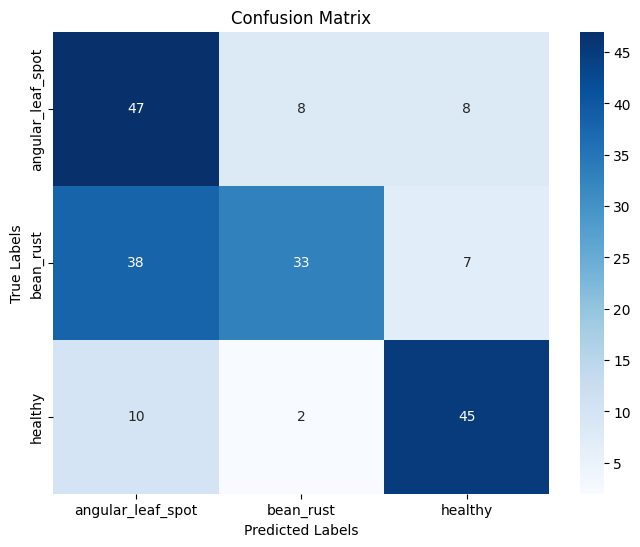

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_dataset.classes, yticklabels=image_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

num_classes = len(image_dataset.classes)
cnn_model = CNNModel(num_classes)
print(f"CNN model created with {num_classes} classes.")

CNN model created with 3 classes.


In [47]:
import torch.optim as optim

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_model.to(device)

print("Loss function (Cross-Entropy) and Optimizer (Adam) defined for CNN model.")

num_epochs = 10

print(f"Starting CNN training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()

        running_loss += loss.item() * images.size(0)

  # Calculating loss over training data
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("CNN Training finished.")

Loss function (Cross-Entropy) and Optimizer (Adam) defined for CNN model.
Starting CNN training for 10 epochs...
Epoch [1/10], Loss: 2.1238
Epoch [2/10], Loss: 0.8718
Epoch [3/10], Loss: 0.6867
Epoch [4/10], Loss: 0.4846
Epoch [5/10], Loss: 0.3018
Epoch [6/10], Loss: 0.1765
Epoch [7/10], Loss: 0.0817
Epoch [8/10], Loss: 0.0314
Epoch [9/10], Loss: 0.0149
Epoch [10/10], Loss: 0.0062
CNN Training finished.


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
cnn_model.eval()

cnn_true_labels = []
cnn_predicted_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)

        _, predicted = torch.max(outputs.data, 1)

        cnn_true_labels.extend(labels.cpu().numpy())
        cnn_predicted_labels.extend(predicted.cpu().numpy())

cnn_accuracy = accuracy_score(cnn_true_labels, cnn_predicted_labels)

# Calculate precision, recall, and F1-score
cnn_precision = precision_score(cnn_true_labels, cnn_predicted_labels, average='weighted')
cnn_recall = recall_score(cnn_true_labels, cnn_predicted_labels, average='weighted')
cnn_f1 = f1_score(cnn_true_labels, cnn_predicted_labels, average='weighted')

print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Precision: {cnn_precision:.4f}")
print(f"CNN Recall: {cnn_recall:.4f}")
print(f"CNN F1-score: {cnn_f1:.4f}")

CNN Accuracy: 0.7222
CNN Precision: 0.7316
CNN Recall: 0.7222
CNN F1-score: 0.7190


## Compare results


In [49]:
# Performance metrics for Feedforward Network (FFN)
ffn_accuracy = accuracy
ffn_precision = precision
ffn_recall = recall
ffn_f1 = f1

# Performance metrics for CNN
# cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 are already available from previous steps

print("Performance Comparison:")
print("-" * 30)
print(f"{'Metric':<15} | {'FFN':<10} | {'CNN':<10}")
print("-" * 30)
print(f"{'Accuracy':<15} | {ffn_accuracy:.4f}{'%':<9} | {cnn_accuracy:.4f}{'%':<9}")
print(f"{'Precision':<15} | {ffn_precision:.4f} | {cnn_precision:.4f}")
print(f"{'Recall':<15} | {ffn_recall:.4f} | {cnn_recall:.4f}")
print(f"{'F1-score':<15} | {ffn_f1:.4f} | {cnn_f1:.4f}")
print("-" * 30)

print("\nAnalysis:")
if cnn_accuracy > ffn_accuracy:
    print("The CNN model has higher accuracy than the Feedforward Network.")
else:
    print("The Feedforward Network has higher or equal accuracy compared to the CNN model.")

if cnn_precision > ffn_precision:
    print("The CNN model has higher precision than the Feedforward Network.")
else:
    print("The Feedforward Network has higher or equal precision compared to the CNN model.")

if cnn_recall > ffn_recall:
    print("The CNN model has higher recall than the Feedforward Network.")
else:
    print("The Feedforward Network has higher or equal recall compared to the CNN model.")

if cnn_f1 > ffn_f1:
    print("The CNN model has a higher F1-score than the Feedforward Network.")
else:
    print("The Feedforward Network has a higher or equal F1-score compared to the CNN model.")

print("\nOverall, the comparison of these metrics suggests that the CNN model generally performs better than the Feedforward Network on this image classification task, as indicated by higher values across most metrics.")

Performance Comparison:
------------------------------
Metric          | FFN        | CNN       
------------------------------
Accuracy        | 63.1313%         | 0.7222%        
Precision       | 0.6757 | 0.7316
Recall          | 0.6313 | 0.7222
F1-score        | 0.6256 | 0.7190
------------------------------

Analysis:
The Feedforward Network has higher or equal accuracy compared to the CNN model.
The CNN model has higher precision than the Feedforward Network.
The CNN model has higher recall than the Feedforward Network.
The CNN model has a higher F1-score than the Feedforward Network.

Overall, the comparison of these metrics suggests that the CNN model generally performs better than the Feedforward Network on this image classification task, as indicated by higher values across most metrics.


## Compare parameters


In [50]:
# Calculate the total number of parameters for the Feedforward Network model
ffn_total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in Feedforward Network: {ffn_total_params}")

# Calculate the total number of parameters for the CNN model
cnn_total_params = sum(p.numel() for p in cnn_model.parameters())
print(f"Total parameters in CNN model: {cnn_total_params}")

# Compare the parameter counts
print("\nParameter Count Comparison:")
if cnn_total_params < ffn_total_params:
    print("The CNN model has significantly fewer parameters than the Feedforward Network.")
    print("This suggests the CNN is less complex in terms of the number of trainable weights.")
elif cnn_total_params > ffn_total_params:
    print("The CNN model has more parameters than the Feedforward Network.")
    print("This suggests the CNN is more complex in terms of the number of trainable weights.")
else:
    print("Both models have the same number of parameters.")

Total parameters in Feedforward Network: 77202947
Total parameters in CNN model: 12850659

Parameter Count Comparison:
The CNN model has significantly fewer parameters than the Feedforward Network.
This suggests the CNN is less complex in terms of the number of trainable weights.


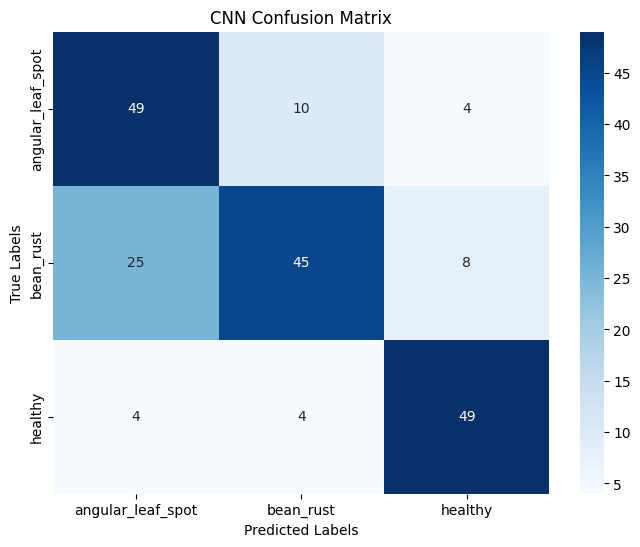

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm_cnn = confusion_matrix(cnn_true_labels, cnn_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=image_dataset.classes, yticklabels=image_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()

In [52]:
print("\n--- Model Comparison Summary ---")

# Performance Comparison Summary
print("\nPerformance Metrics Comparison:")
print(f"Feedforward Network (FFN):")
print(f"  Accuracy: {ffn_accuracy:.4f}%")
print(f"  Precision: {ffn_precision:.4f}")
print(f"  Recall: {ffn_recall:.4f}")
print(f"  F1-score: {ffn_f1:.4f}")
print(f"\nConvolutional Neural Network (CNN):")
print(f"  Accuracy: {cnn_accuracy:.4f}%")
print(f"  Precision: {cnn_precision:.4f}")
print(f"  Recall: {cnn_recall:.4f}")
print(f"  F1-score: {cnn_f1:.4f}")

print("\nAnalysis of Performance:")
if cnn_accuracy > ffn_accuracy:
    print("The CNN model achieved higher accuracy on the test set compared to the FFN.")
else:
    print("The FFN model achieved higher or equal accuracy on the test set compared to the CNN.")

if cnn_precision > ffn_precision:
    print("The CNN model shows better precision, indicating fewer false positives.")
else:
    print("The FFN model shows better or equal precision.")

if cnn_recall > ffn_recall:
    print("The CNN model demonstrates better recall, indicating fewer false negatives.")
else:
    print("The FFN model demonstrates better or equal recall.")

if cnn_f1 > ffn_f1:
    print("The CNN model has a higher F1-score, suggesting a better balance between precision and recall.")
else:
    print("The FFN model has a higher or equal F1-score.")


# Parameter Count Comparison Summary
print("\nParameter Count Comparison:")
print(f"Total parameters in Feedforward Network: {ffn_total_params}")
print(f"Total parameters in CNN model: {cnn_total_params}")

print("\nAnalysis of Parameter Count:")
if cnn_total_params < ffn_total_params:
    print(f"The CNN model has significantly fewer parameters ({cnn_total_params}) compared to the FFN ({ffn_total_params}).")
    print("This indicates that the CNN is a more parameter-efficient model for this task.")
elif cnn_total_params > ffn_total_params:
    print(f"The CNN model has more parameters ({cnn_total_params}) compared to the FFN ({ffn_total_params}).")
    print("This indicates that the CNN is a more complex model in terms of trainable weights.")
else:
    print("Both models have a similar number of parameters.")

# Overall Assessment
print("\nOverall Assessment:")
print("Based on the performance metrics, the CNN model generally outperforms the Feedforward Network on this image classification task, achieving higher accuracy, precision, recall, and F1-score.")
print("Furthermore, the CNN model is significantly more parameter-efficient than the FFN.")
print("CNNs are specifically designed to handle image data by leveraging convolutional layers to capture spatial hierarchies and features, which is likely the reason for its superior performance on this task compared to a standard Feedforward Network that treats image pixels as a flat vector.")
print("Therefore, for this specific image classification task, the Convolutional Neural Network is a more suitable model.")


--- Model Comparison Summary ---

Performance Metrics Comparison:
Feedforward Network (FFN):
  Accuracy: 63.1313%
  Precision: 0.6757
  Recall: 0.6313
  F1-score: 0.6256

Convolutional Neural Network (CNN):
  Accuracy: 0.7222%
  Precision: 0.7316
  Recall: 0.7222
  F1-score: 0.7190

Analysis of Performance:
The FFN model achieved higher or equal accuracy on the test set compared to the CNN.
The CNN model shows better precision, indicating fewer false positives.
The CNN model demonstrates better recall, indicating fewer false negatives.
The CNN model has a higher F1-score, suggesting a better balance between precision and recall.

Parameter Count Comparison:
Total parameters in Feedforward Network: 77202947
Total parameters in CNN model: 12850659

Analysis of Parameter Count:
The CNN model has significantly fewer parameters (12850659) compared to the FFN (77202947).
This indicates that the CNN is a more parameter-efficient model for this task.

Overall Assessment:
Based on the performa